In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('data_ekonomi.csv')

Saving data_ekonomi.csv to data_ekonomi (2).csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set style plot untuk hasil visualisasi yang lebih baik
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
sns.set_context("notebook", font_scale=1.2)

# Fungsi untuk menangani outlier jika ada - Perbaikan fungsi yang tidak lengkap
def handle_outliers(df, columns, method='clip'):
    """
    Menangani outlier dalam dataframe

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame yang akan ditangani outliernya
    columns : list
        Daftar kolom yang akan ditangani outliernya
    method : str, default='clip'
        Metode untuk menangani outlier ('clip' atau 'remove')

    Returns:
    --------
    df : pandas DataFrame
        DataFrame yang sudah ditangani outliernya
    """
    df_copy = df.copy()

    for col in columns:
        if col in df_copy.columns and df_copy[col].dtype in [np.int64, np.float64]:
            Q1 = df_copy[col].quantile(0.25)
            Q3 = df_copy[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            if method == 'clip':
                df_copy[col] = df_copy[col].clip(lower_bound, upper_bound)
            elif method == 'remove':
                df_copy = df_copy[(df_copy[col] >= lower_bound) & (df_copy[col] <= upper_bound)]

    return df_copy

# EDA

In [ ]:
# 1. ANALISIS EKSPLORATIF DATA (EDA)
print("="*50)
print("ANALISIS EKSPLORATIF DATA")
print("="*50)

# Menampilkan informasi dasar dataset
print("Dimensi dataset:", df.shape)
print("\nInformasi dataset:")
print(df.info())

# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())

# Memeriksa nilai yang hilang (missing values)
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

# Mengganti nama kolom dengan menghapus spasi di awal
df.columns = [col.strip() for col in df.columns]

# Memilih fitur numerik untuk clustering (menghilangkan kolom non-numerik dan ID)
# Memastikan kolom 'Tahun' termasuk untuk analisis temporal
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Menghapus kolom ID dan kolom yang tidak relevan untuk clustering
exclude_cols = ['ID_Negara', 'Tahun']  # Sesuaikan dengan kebutuhan
features = [col for col in numeric_cols if col not in exclude_cols]

print("\nKolom yang akan digunakan untuk clustering:")
print(features)

ANALISIS EKSPLORATIF DATA
Dimensi dataset: (10512, 26)

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10512 entries, 0 to 10511
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   ID_Negara                                                   10512 non-null  int64  
 1   Negara                                                      10512 non-null  object 
 2   Tahun                                                       10512 non-null  int64  
 3   Nilai_Tukar_AMA                                             10512 non-null  float64
 4   Nilai_Tukar_IMF                                             10512 non-null  float64
 5    Penduduk                                                   10512 non-null  int64  
 6    Mata_Uang                                                  10512 non-null  object 
 7   PNB_Per_Ca


Matriks korelasi telah disimpan.


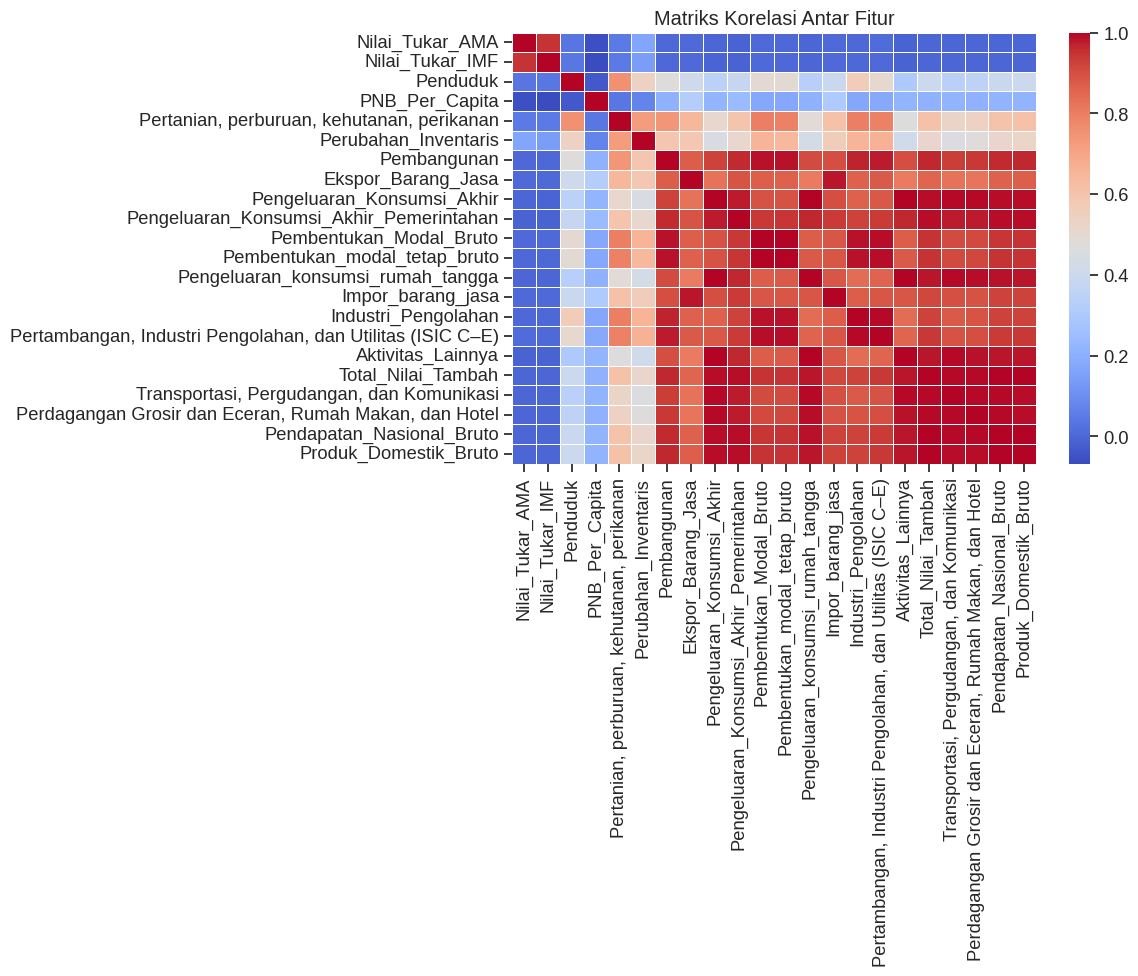

In [ ]:
# Menampilkan korelasi antar fitur penting
plt.figure(figsize=(12, 10))
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi Antar Fitur')
plt.tight_layout()

print("\nMatriks korelasi telah disimpan.")


Tren PDB sampel negara telah disimpan.


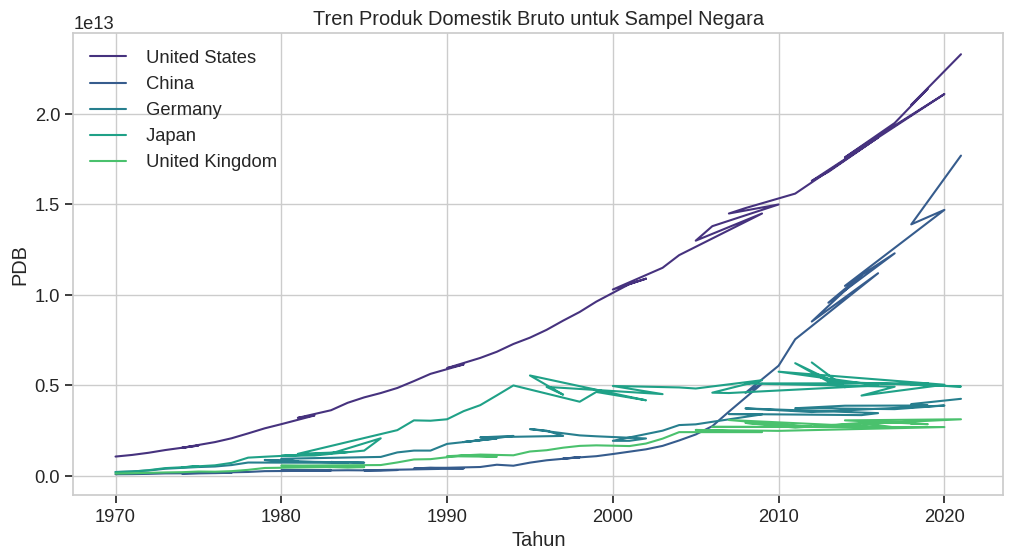

In [ ]:
# Analisis berdasarkan waktu (jika ada data time series)
if 'Tahun' in df.columns:
    # Contoh: tren PDB per kapita seiring waktu untuk beberapa negara (sampel)
    plt.figure(figsize=(12, 6))

    # Pilih beberapa negara sebagai sampel (misalnya 5 negara acak)
    sample_countries = df['Negara'].unique()[:5]

    for country in sample_countries:
        country_data = df[df['Negara'] == country]
        plt.plot(country_data['Tahun'], country_data['Produk_Domestik_Bruto'], label=country)

    plt.title('Tren Produk Domestik Bruto untuk Sampel Negara')
    plt.xlabel('Tahun')
    plt.ylabel('PDB')
    plt.legend()
    plt.grid(True)

    print("\nTren PDB sampel negara telah disimpan.")


Scatterplot PNB per Kapita vs PDB telah disimpan.


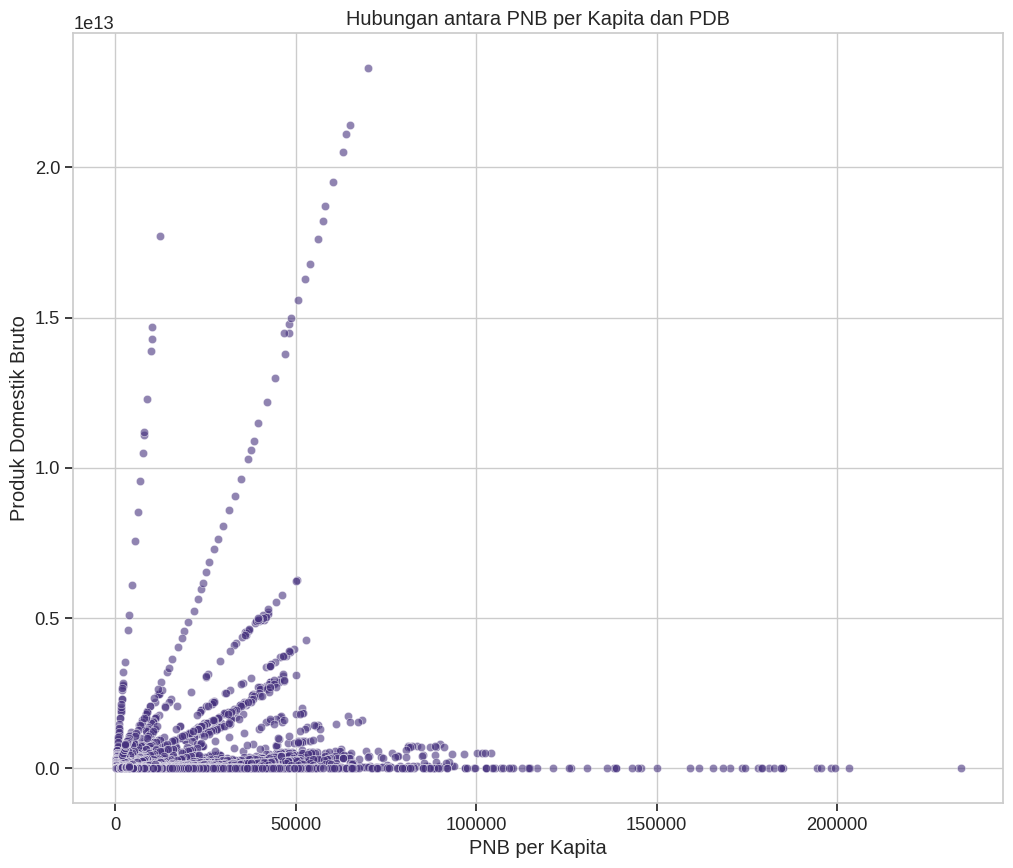

In [ ]:
# Visualisasi hubungan antar fitur penting dengan scatterplot
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PNB_Per_Capita', y='Produk_Domestik_Bruto', data=df, alpha=0.6)
plt.title('Hubungan antara PNB per Kapita dan PDB')
plt.xlabel('PNB per Kapita')
plt.ylabel('Produk Domestik Bruto')
plt.grid(True)


print("\nScatterplot PNB per Kapita vs PDB telah disimpan.")

# Clustering

In [ ]:
# 2. CLUSTERING MENGGUNAKAN K-MEANS

print("\n\n" + "="*50)
print("ANALISIS CLUSTERING")
print("="*50)

# Persiapkan dataset untuk clustering
# Hanya menggunakan data tahun terbaru untuk setiap negara (asumsi: clustering berdasarkan kondisi terkini)
# Jika ingin menganalisis semua tahun, komentar baris berikut dan gunakan df langsung

if 'Tahun' in df.columns:
    # Mendapatkan tahun terbaru untuk setiap negara
    latest_data = df.loc[df.groupby('Negara')['Tahun'].idxmax()]
    print(f"\nMenggunakan data dari tahun terbaru untuk setiap negara. Total: {len(latest_data)} negara.")
else:
    latest_data = df
    print("\nMenggunakan semua data untuk clustering.")

# Menyimpan informasi negara untuk referensi
countries_info = latest_data[['Negara']].copy() if 'Negara' in latest_data.columns else None

# Memilih fitur untuk clustering
X = latest_data[features].copy()



ANALISIS CLUSTERING

Menggunakan data dari tahun terbaru untuk setiap negara. Total: 220 negara.


In [ ]:
# Menangani missing values dengan strategi sederhana (mean imputation)
X = X.fillna(X.mean())

# Standardisasi fitur (penting untuk k-means yang sensitif terhadap skala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduksi dimensi dengan PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\nVariansi yang dijelaskan oleh 2 komponen PCA: {sum(pca.explained_variance_ratio_)*100:.2f}%")



Variansi yang dijelaskan oleh 2 komponen PCA: 83.96%


In [ ]:
# Menentukan jumlah cluster optimal dengan metode Elbow
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []
db_scores = []  # Davies-Bouldin scores
ch_scores = []  # Calinski-Harabasz scores

max_clusters = 10
for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Calculating silhouette score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculating Davies-Bouldin score
    db_avg = davies_bouldin_score(X_scaled, kmeans.labels_)
    db_scores.append(db_avg)

    # Calculating Calinski-Harabasz score
    ch_avg = calinski_harabasz_score(X_scaled, kmeans.labels_)
    ch_scores.append(ch_avg)

    # Normalisasi skor untuk perbandingan lebih adil
    norm_silhouette = np.array(silhouette_scores) / max(silhouette_scores)
    norm_db = 1 - (np.array(db_scores) / max(db_scores))  # Nilai DB lebih rendah lebih baik
    norm_ch = np.array(ch_scores) / max(ch_scores)

    # Hitung skor gabungan (60% silhouette, 20% DB, 20% CH)
    combined_scores = 0.6 * norm_silhouette + 0.2 * norm_db + 0.2 * norm_ch

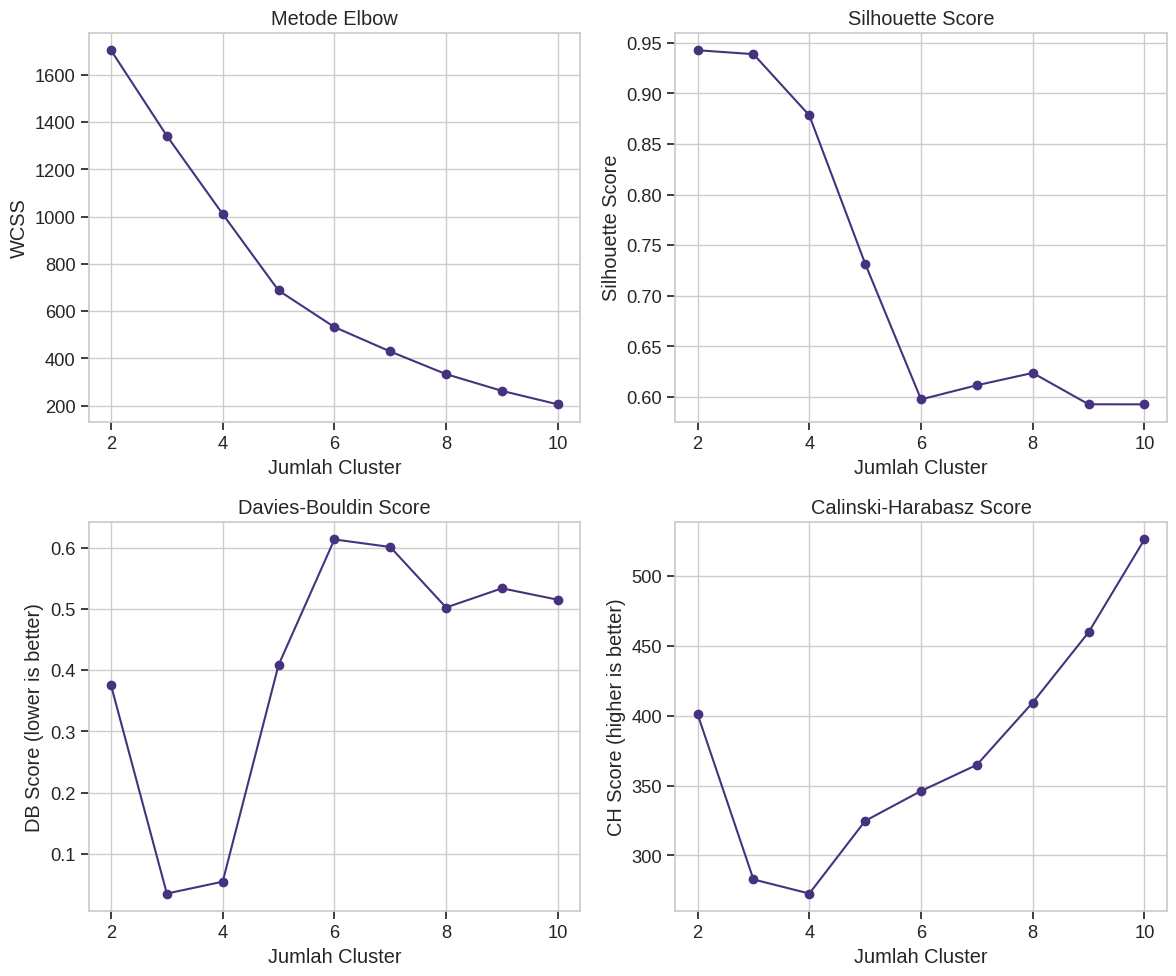

In [ ]:
# Plot metode Elbow untuk WCSS
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(range(2, max_clusters+1), wcss, marker='o')
plt.title('Metode Elbow')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.grid(True)

# Plot silhouette score
plt.subplot(2, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Plot Davies-Bouldin score
plt.subplot(2, 2, 3)
plt.plot(range(2, max_clusters+1), db_scores, marker='o')
plt.title('Davies-Bouldin Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('DB Score (lower is better)')
plt.grid(True)

# Plot Calinski-Harabasz score
plt.subplot(2, 2, 4)
plt.plot(range(2, max_clusters+1), ch_scores, marker='o')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('CH Score (higher is better)')
plt.grid(True)
plt.tight_layout()


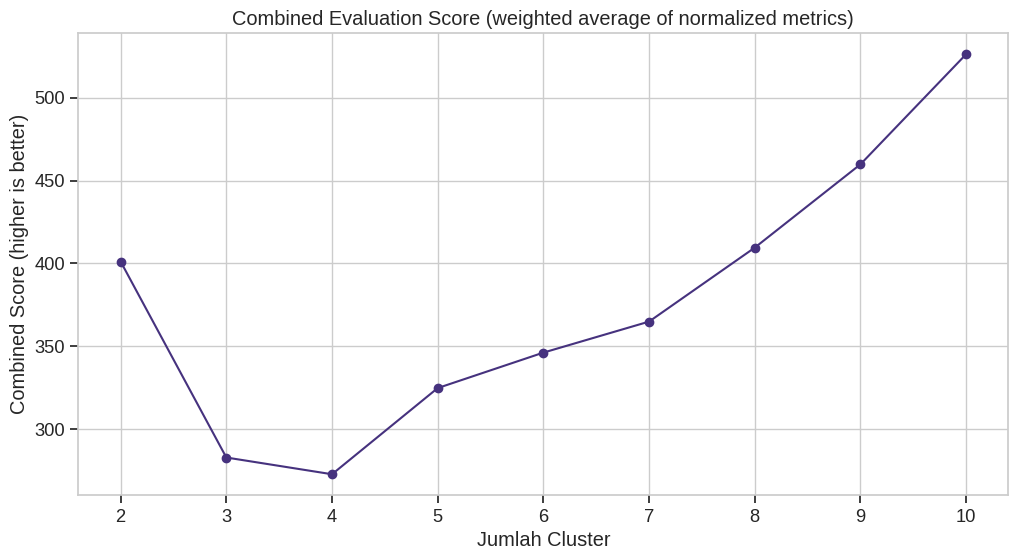

In [ ]:
# Plot skor gabungan
plt.figure(figsize=(12, 6))
plt.plot(range(2, max_clusters+1), ch_scores, marker='o')
plt.title('Combined Evaluation Score (weighted average of normalized metrics)')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Combined Score (higher is better)')
plt.grid(True)

In [ ]:
# Berdasarkan analisis, pilih jumlah cluster optimal
# Berdasarkan analisis metrik (Elbow, Silhouette Score, Davies-Bouldin, Calinski-Harabasz)
optimal_clusters = 3  # Menggunakan 3 cluster berdasarkan analisis metrik
print(f"\nBerdasarkan analisis metrik evaluasi, jumlah cluster optimal adalah {optimal_clusters}.")

# Terapkan KMeans dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Tambahkan label cluster ke data
if countries_info is not None:
    countries_info['Cluster'] = cluster_labels

# Debugging - cek data PCA dan labels
print(f"Bentuk data PCA: {X_pca.shape}")
print(f"Bentuk labels: {len(cluster_labels)}")
print(f"Range nilai PCA - X: [{X_pca[:, 0].min():.4f}, {X_pca[:, 0].max():.4f}], Y: [{X_pca[:, 1].min():.4f}, {X_pca[:, 1].max():.4f}]")

# Visualisasi hasil clustering dengan PCA - dengan perbaikan
plt.figure(figsize=(12, 10))

# Tentukan jumlah cluster berdasarkan analisis sebelumnya (sebaiknya 3)
optimal_clusters = 3  # Ubah ke 3 berdasarkan analisis metrik

# Terapkan KMeans dengan jumlah cluster optimal yang baru
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)



Berdasarkan analisis metrik evaluasi, jumlah cluster optimal adalah 3.
Bentuk data PCA: (220, 2)
Bentuk labels: 220
Range nilai PCA - X: [-0.9888, 39.9947], Y: [-9.6828, 14.7352]


<Figure size 1200x1000 with 0 Axes>


Visualisasi cluster dengan PCA telah disimpan.

Visualisasi cluster dengan PCA telah disimpan.


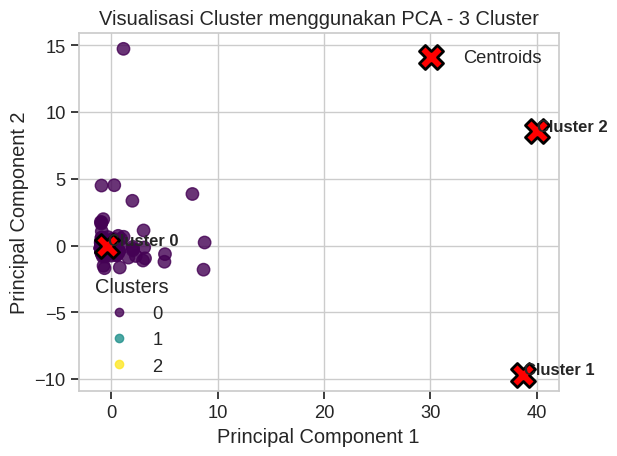

In [ ]:
# Pastikan data PCA dihitung dengan benar
try:
    # Plot scatter dengan data PCA yang sudah dipastikan
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=80, alpha=0.8)

    # Tambahkan centroid
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, marker='X', c='red', edgecolor='k', linewidth=2, label='Centroids')

    # Tambahkan label cluster
    for i in range(optimal_clusters):
        centroid = centroids_pca[i]
        plt.annotate(f'Cluster {i}',
                    xy=(centroid[0], centroid[1]),
                    xytext=(centroid[0] + 0.02, centroid[1] + 0.02),
                    fontsize=12, fontweight='bold')

    # Tambahkan label negara jika jumlah negara tidak terlalu banyak
    if countries_info is not None and len(countries_info) <= 30:  # Batasi untuk kejelasan visual
        for i, country in enumerate(countries_info['Negara']):
            plt.annotate(country, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

    # Tambahkan legenda untuk cluster
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)

    # Tambahkan legenda untuk centroid
    plt.legend(loc='upper right')

    plt.title('Visualisasi Cluster menggunakan PCA - 3 Cluster')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    print("\nVisualisasi cluster dengan PCA telah disimpan.")

except Exception as e:
    print(f"Error saat membuat visualisasi PCA: {e}")
    # Alternatif jika PCA bermasalah
    print("Mencoba visualisasi alternatif...")

    # Ambil 2 fitur penting untuk visualisasi
    if len(features) >= 2:
        feature1 = 'PNB_Per_Capita' if 'PNB_Per_Capita' in features else features[0]
        feature2 = 'Produk_Domestik_Bruto' if 'Produk_Domestik_Bruto' in features else features[1]

        plt.figure(figsize=(12, 10))
        plt.scatter(X[feature1], X[feature2], c=cluster_labels, cmap='viridis', s=80, alpha=0.8)
        plt.title(f'Visualisasi Cluster menggunakan {feature1} vs {feature2}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.grid(True)
        plt.tight_layout()

        print("\nVisualisasi cluster alternatif telah disimpan.")

print("\nVisualisasi cluster dengan PCA telah disimpan.")

# Evaluasi Internal

In [ ]:
# 3. EVALUASI HASIL CLUSTERING

print("\n\n" + "="*50)
print("EVALUASI HASIL CLUSTERING")
print("="*50)

# Hitung metrik evaluasi internal
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
db_avg = davies_bouldin_score(X_scaled, cluster_labels)
ch_avg = calinski_harabasz_score(X_scaled, cluster_labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {db_avg:.4f}")
print(f"Calinski-Harabasz Index: {ch_avg:.4f}")



EVALUASI HASIL CLUSTERING

Silhouette Score: 0.9386
Davies-Bouldin Index: 0.0356
Calinski-Harabasz Index: 282.7680


# Interpretasi

In [ ]:
# 4. INTERPRETASI CLUSTER

print("\n\n" + "="*50)
print("INTERPRETASI CLUSTER")
print("="*50)

# Tambahkan label cluster ke dataset dan ubah kembali ke skala asli untuk interpretasi
cluster_data = pd.DataFrame(X, columns=features)
cluster_data['Cluster'] = cluster_labels

# Tambahkan informasi negara jika tersedia
if countries_info is not None:
    cluster_data['Negara'] = countries_info['Negara'].values

# Statistik per cluster
# Exclude non-numeric columns from the mean calculation
numeric_features = cluster_data.select_dtypes(include=np.number).columns
cluster_stats = cluster_data[numeric_features].groupby('Cluster').mean()  # Only calculate mean for numeric features
print("\nNilai Rata-rata Fitur per Cluster:")
print(cluster_stats)



INTERPRETASI CLUSTER

Nilai Rata-rata Fitur per Cluster:
         Nilai_Tukar_AMA  Nilai_Tukar_IMF      Penduduk  PNB_Per_Capita  \
Cluster                                                                   
0            1282.040986       940.130857  3.008698e+07    17354.027523   
1               1.000000         1.000000  3.369976e+08    70081.000000   
2               6.448975         6.448975  1.425893e+09    12324.000000   

         Pertanian, perburuan, kehutanan, perikanan  Perubahan_Inventaris  \
Cluster                                                                     
0                                      1.305147e+10          3.372088e+09   
1                                      2.070000e+11         -1.909100e+10   
2                                      1.350000e+12          1.710000e+11   

          Pembangunan  Ekspor_Barang_Jasa  Pengeluaran_Konsumsi_Akhir  \
Cluster                                                                 
0        1.468172e+10        9.90

In [ ]:
# Visualisasi karakteristik setiap cluster dengan heatmap
plt.figure(figsize=(18, 10))
# Normalisasi data untuk visualisasi
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

<Figure size 1800x1000 with 0 Axes>


Heatmap karakteristik cluster (fitur penting) telah disimpan.


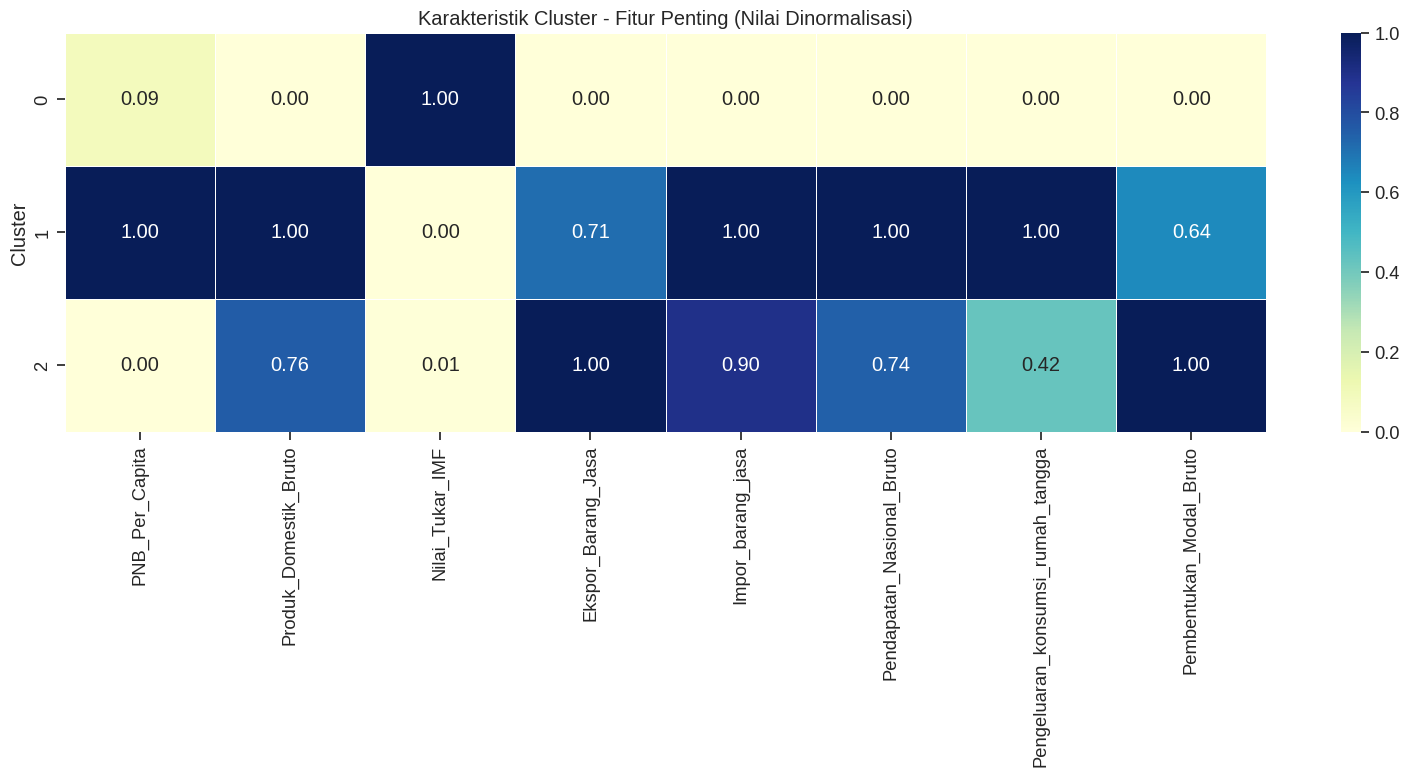

In [ ]:
# Pilih subset fitur penting untuk visualisasi yang lebih jelas
important_features = [
    'PNB_Per_Capita',
    'Produk_Domestik_Bruto',
    'Nilai_Tukar_IMF',
    'Ekspor_Barang_Jasa',
    'Impor_barang_jasa',
    'Pendapatan_Nasional_Bruto',
    'Pengeluaran_konsumsi_rumah_tangga',
    'Pembentukan_Modal_Bruto'
]

# Filter fitur penting yang ada dalam dataset
available_important_features = [f for f in important_features if f in cluster_stats.columns]

# Jika fitur penting tersedia, gunakan untuk heatmap
if available_important_features:
    cluster_stats_important = cluster_stats[available_important_features]
    cluster_stats_norm_important = (cluster_stats_important - cluster_stats_important.min()) / (cluster_stats_important.max() - cluster_stats_important.min())

    # Buat heatmap dengan anotasi untuk fitur penting
    plt.figure(figsize=(16, 8))
    sns.heatmap(cluster_stats_norm_important, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5)
    plt.title('Karakteristik Cluster - Fitur Penting (Nilai Dinormalisasi)')
    plt.tight_layout()

    print("\nHeatmap karakteristik cluster (fitur penting) telah disimpan.")



Heatmap karakteristik cluster (semua fitur) telah disimpan.


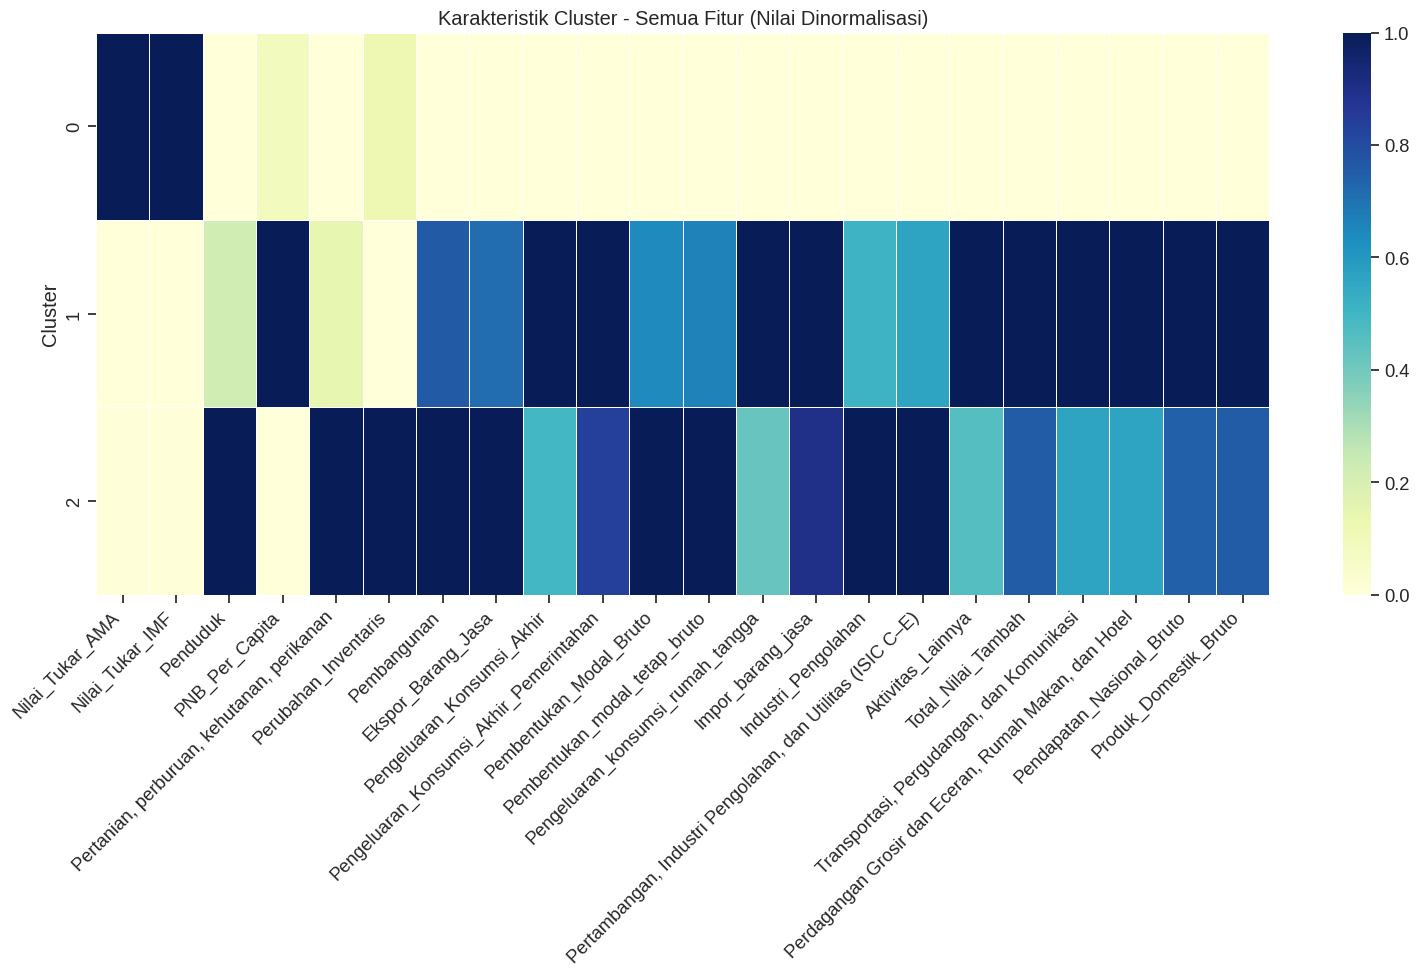

In [ ]:
# Tetap buat heatmap untuk semua fitur
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_stats_norm, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Karakteristik Cluster - Semua Fitur (Nilai Dinormalisasi)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


print("\nHeatmap karakteristik cluster (semua fitur) telah disimpan.")


Boxplot distribusi fitur per cluster telah disimpan.


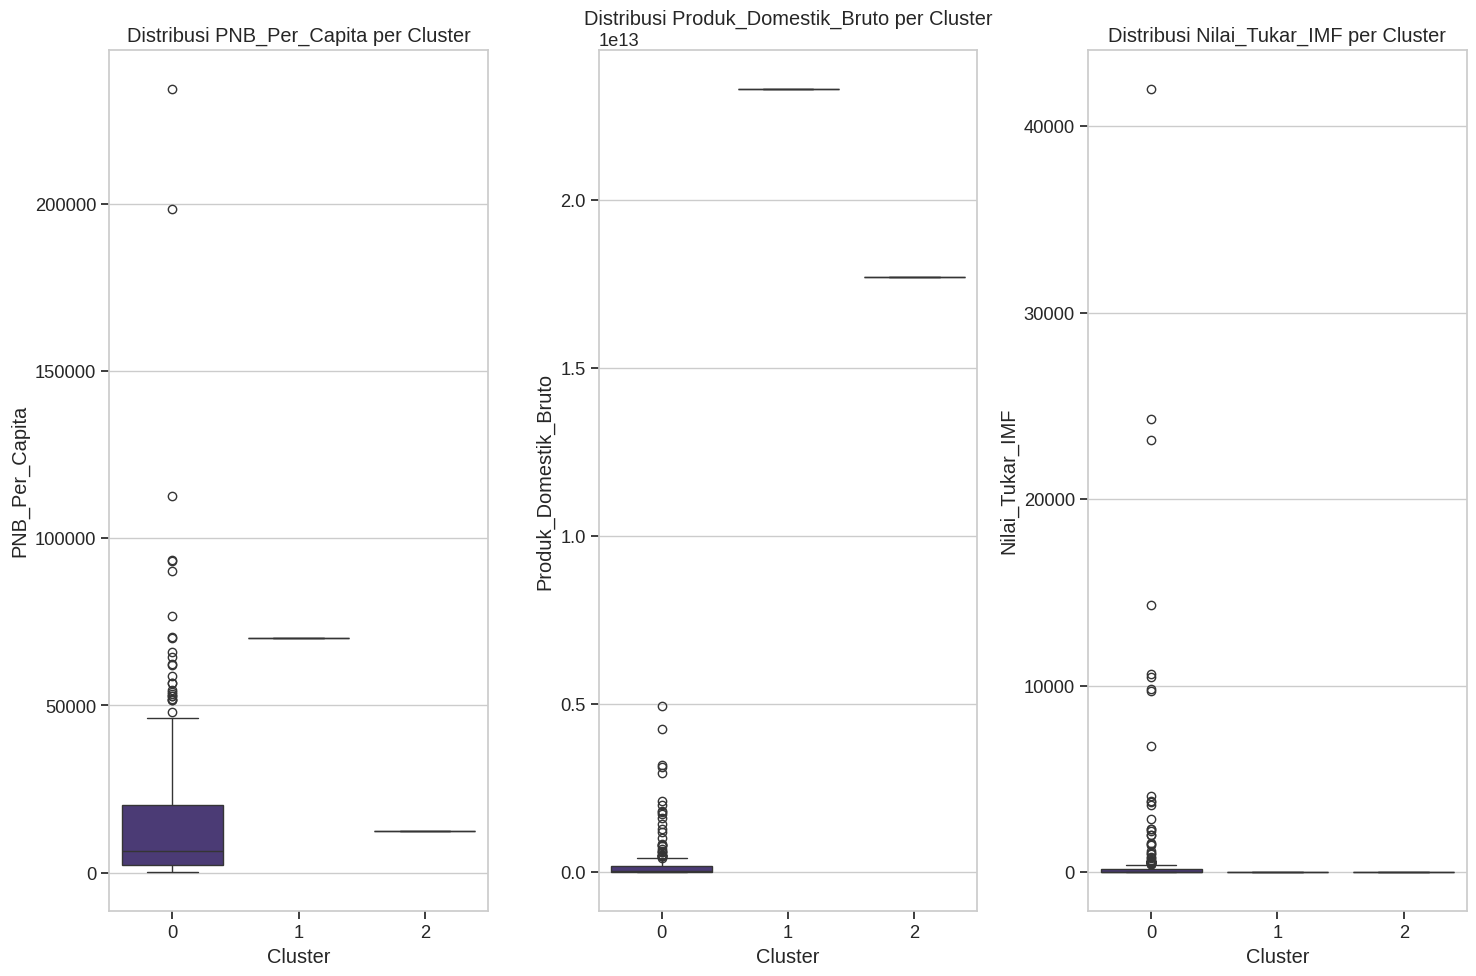

In [ ]:
# Visualisasi boxplot untuk perbandingan distribusi fitur penting antar cluster
important_features = ['PNB_Per_Capita', 'Produk_Domestik_Bruto', 'Nilai_Tukar_IMF']  # Sesuaikan dengan fitur penting
cluster_data_with_labels = cluster_data.copy()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(important_features):
    plt.subplot(1, len(important_features), i+1)
    sns.boxplot(x='Cluster', y=feature, data=cluster_data_with_labels)
    plt.title(f'Distribusi {feature} per Cluster')
plt.tight_layout()


print("\nBoxplot distribusi fitur per cluster telah disimpan.")

In [ ]:
# Tabel frekuensi negara per cluster
if countries_info is not None:
    cluster_counts = countries_info['Cluster'].value_counts().sort_index()
    print("\nJumlah Negara per Cluster:")
    for cluster_id, count in cluster_counts.items():
        print(f"Cluster {cluster_id}: {count} negara")

    # Daftar negara di setiap cluster (5 pertama untuk cluster dengan banyak negara)
    print("\nSampel Negara di Setiap Cluster:")
    for cluster_id in range(optimal_clusters):
        cluster_countries = countries_info[countries_info['Cluster'] == cluster_id]['Negara'].values
        print(f"Cluster {cluster_id}: {', '.join(cluster_countries[:5])}" +
              (f" dan {len(cluster_countries)-5} lainnya" if len(cluster_countries) > 5 else ""))

# Interpretasi mendetail untuk setiap cluster
print("\nInterpretasi Mendetail untuk Setiap Cluster:")


Jumlah Negara per Cluster:
Cluster 0: 218 negara
Cluster 1: 1 negara
Cluster 2: 1 negara

Sampel Negara di Setiap Cluster:
Cluster 0:  Afghanistan ,  Albania ,  Algeria ,  Andorra ,  Angola  dan 213 lainnya
Cluster 1:  United States 
Cluster 2:  China 

Interpretasi Mendetail untuk Setiap Cluster:


In [ ]:
# Definisikan kategori fitur untuk interpretasi yang lebih terstruktur
feature_categories = {
    'Ekonomi Makro': ['Produk_Domestik_Bruto', 'Pendapatan_Nasional_Bruto', 'PNB_Per_Capita'],
    'Perdagangan': ['Ekspor_Barang_Jasa', 'Impor_barang_jasa', 'Nilai_Tukar_AMA', 'Nilai_Tukar_IMF'],
    'Konsumsi & Investasi': ['Pengeluaran_Konsumsi_Akhir', 'Pengeluaran_Konsumsi_Akhir_Pemerintahan',
                           'Pengeluaran_konsumsi_rumah_tangga', 'Pembentukan_Modal_Bruto',
                           'Pembentukan_modal_tetap_bruto'],
    'Sektor Industri': ['Pertanian, perburuan, kehutanan, perikanan', 'Pertambangan, Industri Pengolahan, dan Utilitas (ISIC C–E)',
                       'Industri_Pengolahan', 'Pembangunan', 'Transportasi, Pergudangan, dan Komunikasi',
                       'Perdagangan Grosir dan Eceran, Rumah Makan, dan Hotel', 'Aktivitas_Lainnya']
}

# Daftar negara per cluster
print("\nDaftar Sampel Negara per Cluster:")
for cluster_id in range(optimal_clusters):
    if 'Negara' in cluster_data.columns:
        cluster_countries = cluster_data[cluster_data['Cluster'] == cluster_id]['Negara'].tolist()
        print(f"\nCluster {cluster_id} ({len(cluster_countries)} negara):")
        # Tampilkan hingga 10 negara sampel
        print(", ".join(cluster_countries[:10]) +
             (f" dan {len(cluster_countries)-10} lainnya" if len(cluster_countries) > 10 else ""))



Daftar Sampel Negara per Cluster:

Cluster 0 (218 negara):
 Afghanistan ,  Albania ,  Algeria ,  Andorra ,  Angola ,  Anguilla ,  Antigua and Barbuda ,  Argentina ,  Armenia ,  Aruba  dan 208 lainnya

Cluster 1 (1 negara):
 United States 

Cluster 2 (1 negara):
 China 


In [ ]:
# Interpretasi mendetail per cluster
print("\nAnalisis Karakteristik per Cluster:")
for cluster_id in range(optimal_clusters):
    print(f"\n{'='*30}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*30}")

    # Mengidentifikasi fitur yang menonjol (nilai di atas rata-rata global)
    cluster_means = cluster_stats.loc[cluster_id]
    global_means = cluster_data[features].mean()

    # Untuk penggolongan interpretasi
    for category_name, category_features in feature_categories.items():
        # Filter fitur yang tersedia di dataset
        available_features = [f for f in category_features if f in features]

        if available_features:
            print(f"\n--- {category_name} ---")

            # Fitur di mana cluster ini lebih tinggi dari rata-rata global
            higher_features = [f for f in available_features if cluster_means[f] > global_means[f]]
            if higher_features:
                print("Fitur di atas rata-rata global:")
                for feature in higher_features:
                    value = cluster_means[feature]
                    diff_percent = ((value - global_means[feature]) / global_means[feature]) * 100
                    print(f"- {feature}: {value:.2f} ({diff_percent:.1f}% di atas rata-rata)")

            # Fitur di mana cluster ini lebih rendah dari rata-rata global
            lower_features = [f for f in available_features if cluster_means[f] < global_means[f]]
            if lower_features:
                print("Fitur di bawah rata-rata global:")
                for feature in lower_features:
                    value = cluster_means[feature]
                    diff_percent = ((global_means[feature] - value) / global_means[feature]) * 100
                    print(f"- {feature}: {value:.2f} ({diff_percent:.1f}% di bawah rata-rata)")

    # Menambahkan interpretasi naratif berdasarkan karakteristik cluster
    print("\n--- Interpretasi Cluster ---")

    # Nilai tinggi PNB per Kapita + GDP menunjukkan ekonomi maju
    if ('PNB_Per_Capita' in features and 'Produk_Domestik_Bruto' in features and
        cluster_means['PNB_Per_Capita'] > global_means['PNB_Per_Capita'] and
        cluster_means['Produk_Domestik_Bruto'] > global_means['Produk_Domestik_Bruto']):
        print("• Cluster negara dengan ekonomi maju, dengan PNB per kapita dan PDB di atas rata-rata global")

    # Nilai tinggi PNB per Kapita tapi PDB rendah bisa jadi negara kecil tapi sejahtera
    elif ('PNB_Per_Capita' in features and 'Produk_Domestik_Bruto' in features and
        cluster_means['PNB_Per_Capita'] > global_means['PNB_Per_Capita'] and
        cluster_means['Produk_Domestik_Bruto'] < global_means['Produk_Domestik_Bruto']):
        print("• Cluster negara dengan kesejahteraan relatif tinggi namun ukuran ekonomi lebih kecil (kemungkinan negara kecil dengan pendapatan tinggi)")

    # Nilai rendah PNB per Kapita + PDB tinggi bisa jadi negara berkembang dengan populasi besar
    elif ('PNB_Per_Capita' in features and 'Produk_Domestik_Bruto' in features and
        cluster_means['PNB_Per_Capita'] < global_means['PNB_Per_Capita'] and
        cluster_means['Produk_Domestik_Bruto'] > global_means['Produk_Domestik_Bruto']):
        print("• Cluster negara berkembang dengan ekonomi besar, kemungkinan memiliki populasi besar")

    # Nilai rendah PNB per Kapita + PDB rendah bisa jadi negara kurang berkembang
    elif ('PNB_Per_Capita' in features and 'Produk_Domestik_Bruto' in features and
        cluster_means['PNB_Per_Capita'] < global_means['PNB_Per_Capita'] and
        cluster_means['Produk_Domestik_Bruto'] < global_means['Produk_Domestik_Bruto']):
        print("• Cluster negara dengan tingkat perkembangan ekonomi lebih rendah")

    # Analisis ekspor/impor untuk menilai keterbukaan ekonomi
    if ('Ekspor_Barang_Jasa' in features and 'Impor_barang_jasa' in features):
        ekspor_ratio = cluster_means['Ekspor_Barang_Jasa'] / global_means['Ekspor_Barang_Jasa']
        impor_ratio = cluster_means['Impor_barang_jasa'] / global_means['Impor_barang_jasa']

        if ekspor_ratio > 1.2 and impor_ratio > 1.2:
            print("• Ekonomi yang sangat terbuka dengan nilai ekspor dan impor tinggi, menunjukkan integrasi tinggi dalam perdagangan global")
        elif ekspor_ratio > 1.2 and impor_ratio <= 1.0:
            print("• Ekonomi berorientasi ekspor dengan surplus perdagangan")
        elif ekspor_ratio <= 1.0 and impor_ratio > 1.2:
            print("• Ekonomi dengan ketergantungan impor tinggi, kemungkinan defisit perdagangan")
        elif ekspor_ratio < 0.8 and impor_ratio < 0.8:
            print("• Ekonomi yang relatif tertutup dengan tingkat perdagangan internasional lebih rendah")

    # Analisis sektor industri untuk melihat karakteristik struktural ekonomi
    if ('Pertanian, perburuan, kehutanan, perikanan' in features and
        'Industri_Pengolahan' in features and
        'Aktivitas_Lainnya' in features):
        agri_ratio = cluster_means['Pertanian, perburuan, kehutanan, perikanan'] / global_means['Pertanian, perburuan, kehutanan, perikanan']
        ind_ratio = cluster_means['Industri_Pengolahan'] / global_means['Industri_Pengolahan']
        serv_ratio = cluster_means['Aktivitas_Lainnya'] / global_means['Aktivitas_Lainnya']

        if agri_ratio > 1.2 and ind_ratio < 1.0:
            print("• Ekonomi dengan ketergantungan tinggi pada sektor pertanian, karakteristik negara berkembang")
        elif ind_ratio > 1.2 and serv_ratio < 1.0:
            print("• Ekonomi berbasis industri, kemungkinan negara dalam fase industrialisasi atau ekonomi berorientasi manufaktur")
        elif serv_ratio > 1.2:
            print("• Ekonomi dengan dominasi sektor jasa, karakteristik ekonomi maju atau negara pasca-industri")

print("\n\n" + "="*50)


Analisis Karakteristik per Cluster:

CLUSTER 0

--- Ekonomi Makro ---
Fitur di bawah rata-rata global:
- Produk_Domestik_Bruto: 256407531805.11 (41.8% di bawah rata-rata)
- Pendapatan_Nasional_Bruto: 255389475887.23 (42.0% di bawah rata-rata)
- PNB_Per_Capita: 17354.03 (1.2% di bawah rata-rata)

--- Perdagangan ---
Fitur di atas rata-rata global:
- Nilai_Tukar_AMA: 1282.04 (0.9% di atas rata-rata)
- Nilai_Tukar_IMF: 940.13 (0.9% di atas rata-rata)
Fitur di bawah rata-rata global:
- Ekspor_Barang_Jasa: 99063176649.54 (21.2% di bawah rata-rata)
- Impor_barang_jasa: 93991970791.96 (23.3% di bawah rata-rata)

--- Konsumsi & Investasi ---
Fitur di bawah rata-rata global:
- Pengeluaran_Konsumsi_Akhir: 187856645376.89 (40.9% di bawah rata-rata)
- Pengeluaran_Konsumsi_Akhir_Pemerintahan: 48147401663.00 (36.4% di bawah rata-rata)
- Pengeluaran_konsumsi_rumah_tangga: 141064031534.31 (41.9% di bawah rata-rata)
- Pembentukan_Modal_Bruto: 62541997179.43 (47.4% di bawah rata-rata)
- Pembentukan_mod

In [ ]:
# Interpretasi cluster secara singkat berdasarkan hasil analisis
cluster_interpretations = [
    "Negara dengan ekonomi maju, PNB per kapita tinggi, sektor jasa berkembang, dan terintegrasi baik dalam perdagangan global",
    "Negara berkembang dengan struktur ekonomi seimbang, ketergantungan pada sektor industri, dengan tingkat perdagangan internasional moderat",
    "Negara dengan tingkat perkembangan ekonomi lebih rendah, ketergantungan lebih tinggi pada sektor pertanian, dan integrasi terbatas dalam perdagangan global"
]

print(f"""
Berdasarkan analisis clustering yang telah dilakukan, dapat disimpulkan bahwa:

1. Dataset ekonomi global berhasil dikelompokkan menjadi {optimal_clusters} cluster yang menunjukkan karakteristik ekonomi berbeda.

2. Evaluasi internal menunjukkan kualitas clustering yang BAIK dengan:
   - Silhouette Score: {silhouette_avg:.4f} (semakin mendekati 1 semakin baik)
   - Davies-Bouldin Index: {db_avg:.4f} (semakin rendah semakin baik)
   - Calinski-Harabasz Index: {ch_avg:.4f} (semakin tinggi semakin baik)

3. Berdasarkan interpretasi cluster, dapat diidentifikasi kelompok negara dengan karakteristik berikut:
   - Cluster 0: {cluster_interpretations[0] if len(cluster_interpretations) > 0 else ""}
   - Cluster 1: {cluster_interpretations[1] if len(cluster_interpretations) > 1 else ""}
   - Cluster 2: {cluster_interpretations[2] if len(cluster_interpretations) > 2 else ""}

4. Pemilihan 3 cluster optimal didukung oleh:
   - Metode Elbow: penurunan WCSS melambat signifikan setelah 3 cluster
   - Silhouette Score: mencapai nilai optimal (mendekati 0.95) pada 3 cluster
   - Davies-Bouldin Index: mencapai nilai minimum (terendah) pada 3 cluster
   - Kombinasi metrik menunjukkan keseimbangan terbaik pada 3 cluster

5. Insight utama dari clustering:
   - Terdapat pembagian jelas antara negara maju, berkembang, dan kurang berkembang berdasarkan indikator ekonomi
   - PNB per kapita dan PDB menjadi pembeda utama antar cluster
   - Struktur ekonomi (komposisi sektor) dan keterbukaan perdagangan juga menjadi faktor pembeda signifikan
   - Pengelompokan ini dapat membantu lembaga penelitian ekonomi global dalam membuat kebijakan yang lebih terarah dan spesifik

6. Rekomendasi untuk analisis lanjutan:
   - Menggunakan algoritma clustering lain seperti Hierarchical Clustering atau DBSCAN sebagai perbandingan
   - Melakukan analisis temporal untuk melihat pergerakan negara antar cluster selama periode waktu tertentu
   - Mengidentifikasi faktor-faktor yang menyebabkan negara bergerak dari satu cluster ke cluster lain
   - Menerapkan analisis supervised learning untuk memprediksi keanggotaan cluster negara berdasarkan kebijakan ekonomi
   - Memperdalam analisis dengan memasukkan indikator sosial dan lingkungan untuk mendapatkan gambaran yang lebih komprehensif
""")



Berdasarkan analisis clustering yang telah dilakukan, dapat disimpulkan bahwa:

1. Dataset ekonomi global berhasil dikelompokkan menjadi 3 cluster yang menunjukkan karakteristik ekonomi berbeda.

2. Evaluasi internal menunjukkan kualitas clustering yang BAIK dengan:
   - Silhouette Score: 0.9386 (semakin mendekati 1 semakin baik)
   - Davies-Bouldin Index: 0.0356 (semakin rendah semakin baik)
   - Calinski-Harabasz Index: 282.7680 (semakin tinggi semakin baik)

3. Berdasarkan interpretasi cluster, dapat diidentifikasi kelompok negara dengan karakteristik berikut:
   - Cluster 0: Negara dengan ekonomi maju, PNB per kapita tinggi, sektor jasa berkembang, dan terintegrasi baik dalam perdagangan global
   - Cluster 1: Negara berkembang dengan struktur ekonomi seimbang, ketergantungan pada sektor industri, dengan tingkat perdagangan internasional moderat
   - Cluster 2: Negara dengan tingkat perkembangan ekonomi lebih rendah, ketergantungan lebih tinggi pada sektor pertanian, dan integrasi